# Contributions
All members contributed to the development of RL agents and production of this report equally.




# Import Dependencies


In [4]:
import numpy as np
import gym
import pickle
import matplotlib.pyplot as plt

from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# Load Cartpole Environment

Here we will create the cartpole environment using the gym library. Then we will check the action space and observation space to get a overview of this environment.   

### Action Space
The action is an ndarray with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.   

### Observation Space
The observation is an ndarray with shape (4,) with the values corresponding to the following positions and velocities:

In [5]:
env = gym.make('CartPole-v1')
print("Shape of action space: ",env.action_space)
print("Shape of observation space: ", env.observation_space.shape[0])

Shape of action space:  Discrete(2)
Shape of observation space:  4


---

# Task 1: Development of an RL agent

In this section, we will develop several RL agent for comparison

## 1.1 Develpoing Q-learning Agent

The first agent we will implement is the Q-learning agent which is an off-policy reinforcement learning that will find the bet course of action given the current state of the agent.

#### Q-Learning Equation

$$ Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1}+ \gamma \underset{a}{max} Q_{old}(S_{t+1}, a) - Q_{old}(S_{t}, A_{t})) $$

We implemented our Q-agent using the formula taught in lecture for updating the Q-table.   

#### Exploration Rate   

We introduced epsilon and epsilon decay which is the exploration rate. This is to encourage exploration during the beginning of the training. Exploration rate should decrease as the agent gain more experience to reduce the randomness of actions.   


In [18]:
class QLearningAgent:
    """Q-Learning agent

    Attributes:
        env: OpenAI Gym environment
        q: Q table
        pos_space: position space
        vel_space: velocity space
        ang_space: pole angle space
        ang_vel_space: pole angular velocity space
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration rate
        epsilon_decay: exploration rate decay
    """
    def __init__(self, env):
        # Environment
        self.env = env

        # Divide position, velocity, pole angle, and pole angular velocity into segments
        self.pos_space = np.linspace(-2.4, 2.4, 7) 
        self.vel_space = np.linspace(-4.0, 4.0, 7) 
        self.ang_space = np.linspace(-.2095, .2095, 7)
        self.ang_vel_space = np.linspace(-4.0, 4.0, 7)

        # Initialize Q table
        self.q = np.zeros((len(self.pos_space)+1, len(self.vel_space)+1, len(self.ang_space)+1, len(self.ang_vel_space)+1, self.env.action_space.n)) 

        # Hyperparameters
        self.alpha = 0.1 # learning rate
        self.gamma = 0.95 # discount factor
        self.epsilon = 0.1 # exploration rate
        self.epsilon_decay = 0.00001 # exploration rate decay

        self.rng = np.random.default_rng() # Random number generator

    """Run one episode of the environment
    
    Args:
        is_training: boolean to indicate if the agent is training or testing
    """
    def run_one_episode(self, is_training=True):
        # Get initial state
        state = self.env.reset()[0]

        # Discretize state
        state_p = np.digitize(state[0], self.pos_space) 
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)

        # Initialize variables
        terminated = False
        rewards = 0

        # Loop through one episode
        while(not terminated):
            # Choose action based on epsilon-greedy policy
            if is_training and np.random.uniform() < self.epsilon:
                action = self.env.action_space.sample()
            else:
                action = np.argmax(self.q[state_p, state_v, state_a, state_av, :]) # Choose action based on Q table
         
              
            # Take action, get new state and reward
            new_state, reward, terminated, _, _ = self.env.step(action)
            new_state_p = np.digitize(new_state[0], self.pos_space)
            new_state_v = np.digitize(new_state[1], self.vel_space)
            new_state_a = np.digitize(new_state[2], self.ang_space)
            new_state_av = np.digitize(new_state[3], self.ang_vel_space)
            # Update Q table based on Bellman equation
            if is_training:
                self.q[state_p, state_v, state_a, state_av, action] = self.q[state_p, state_v, state_a, state_av, action] + self.alpha * (
                    reward + self.gamma*np.max(self.q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - self.q[state_p, state_v, state_a, state_av, action]
                )
            # Update state
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av = new_state_av
            rewards += reward
        return rewards
    
    """
    Train the agent
    
    Args:
        min_rewards: minimum rewards to stop training
        plot: boolean to indicate if the rewards should be plotted
    """
    def train(self, min_rewards=300, plot=False):
        rewards_per_episode = []
        i = 0

        # Loop through episodes
        while True:
            rewards = self.run_one_episode() # Run one episode
            rewards_per_episode.append(rewards) # Append rewards
            mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):]) # Mean rewards of last 100 episodes
            if i%100==0:
                print(f'Episode: {i} Rewards: {rewards}  Epsilon: {self.epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')
            if mean_rewards > min_rewards:
                break
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.1) # Decay epsilon
            i += 1
        self.env.close()

        # plot rewards
        if plot:
            self.plot_rewards(rewards_per_episode)

    """
    Train the agent by episodes
    
    Args:
        num_episodes: number of episodes to train
        plot: boolean to indicate if the rewards should be plotted
    """
    def train_by_episodes(self, num_episodes=1000, plot=False):
        rewards_per_episode = []
        for i in range(num_episodes):
            rewards = self.run_one_episode()
            rewards_per_episode.append(rewards)
            mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):])
            if i%100==0:
                print(f'Episode: {i} Rewards: {rewards}  Epsilon: {self.epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.01)
        self.env.close()

        # plot rewards
        if plot:
            self.plot_rewards(rewards_per_episode)
    

    """
    Test the agent
    
    Args:
        num_episodes: number of episodes to test
        plot: boolean to indicate if the rewards should be plotted
    """
    def test(self, num_episodes=100, plot=True):
        rewards_per_episode = []
        for i in range(num_episodes):
            rewards = self.run_one_episode(is_training=False) # Run one episode
            rewards_per_episode.append(rewards) # Append rewards
            print(f'Episode: {i+1} Rewards: {rewards}')
        print(f'Cummulative average rewards: {np.mean(rewards_per_episode)}')

        # plot rewards
        if plot:
            plt.plot(rewards_per_episode)
            plt.xlabel('Episodes')
            plt.ylabel('Rewards')
            plt.title(f'Rewards vs Episodes)')
            plt.savefig('cartpoleQLAgent_test.png')
        
        return np.mean(rewards_per_episode)

    """
    Show the action

    """
    def show_action(self):
        # Get initial state
        state = self.env.reset()[0]

        # Discretize state
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)

        # Choose action based on Q table
        action = np.argmax(self.q[state_p, state_v, state_a, state_av, :]) 

        # Print state and action
        print(f"Observations: {state}")
        print(f"Chosen Action: {action}")

    """
    Get the action

    Args:
        state: state of the environment
    """
    def predict(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)
        action = np.argmax(self.q[state_p, state_v, state_a, state_av, :])
        return action

    """
    Save and load the model
    
    Args:
        filename: name of the file to save/load the model
    """
    def save_model(self, filename='cartpoleQLAgent.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self.q, f)

    """
    Load the model
    
    Args:
        filename: name of the file to load the model
    """
    def load_model(self, filename='cartpoleQLAgent.pkl'):
        with open(filename, 'rb') as f:
            self.q = pickle.load(f)

    """
    Plot the rewards
    
    Args:
        rewards_array: array of rewards
    """
    def plot_rewards(self, rewards_array):
        mean_rewards = []
        for t in range(len(rewards_array)):
            mean_rewards.append(np.mean(rewards_array[max(0, t-100):(t+1)]))
        plt.plot(mean_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Mean Rewards')
        plt.title(f'Mean Rewards vs Episodes (lr={self.alpha}, er={self.epsilon:0.2f})')
        plt.savefig('cartpoleQLAgent.png')


Episode: 0 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 9.0
Episode: 100 Rewards: 34.0  Epsilon: 0.10  Mean Rewards 26.3
Episode: 200 Rewards: 20.0  Epsilon: 0.10  Mean Rewards 28.1
Episode: 300 Rewards: 45.0  Epsilon: 0.10  Mean Rewards 28.8
Episode: 400 Rewards: 53.0  Epsilon: 0.10  Mean Rewards 33.2
Episode: 500 Rewards: 33.0  Epsilon: 0.10  Mean Rewards 36.5
Episode: 600 Rewards: 31.0  Epsilon: 0.10  Mean Rewards 42.7
Episode: 700 Rewards: 82.0  Epsilon: 0.10  Mean Rewards 59.5
Episode: 800 Rewards: 62.0  Epsilon: 0.10  Mean Rewards 77.1
Episode: 900 Rewards: 88.0  Epsilon: 0.10  Mean Rewards 77.3
Episode: 1000 Rewards: 91.0  Epsilon: 0.10  Mean Rewards 96.8
Episode: 1100 Rewards: 32.0  Epsilon: 0.10  Mean Rewards 93.8


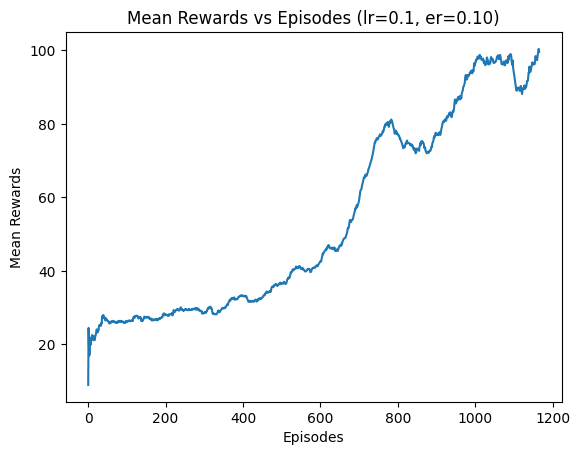

In [19]:
# Train the agent to reach a minimum of 100 avg rewards
agent = QLearningAgent(env)
agent.train(min_rewards=100, plot=True)
agent.save_model()

### Correctness of Implementation
Print the values of the state and chosen action in Jupyter notebook.

In [20]:
agent.show_action()

Observations: [ 0.04076441  0.02802951  0.04731782 -0.00934625]
Chosen Action: 0


## 1.2 Hyperparameter Exploration and Tuning

#### Vary Learning Rate

What we want to do now is to investigate the effect of different initial learning rate on the number of episodes needed to reach an average reward of 200.

Here we look at learning rate at 0.05, 0.1, 0.15, 0.2 while keeping the initial exploration rate at 0.1

Episode: 0 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 100 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 16.6
Episode: 200 Rewards: 22.0  Epsilon: 0.10  Mean Rewards 16.7
Episode: 300 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 16.7
Episode: 400 Rewards: 11.0  Epsilon: 0.10  Mean Rewards 16.9
Episode: 500 Rewards: 12.0  Epsilon: 0.10  Mean Rewards 17.0
Episode: 600 Rewards: 29.0  Epsilon: 0.10  Mean Rewards 16.4
Episode: 700 Rewards: 11.0  Epsilon: 0.10  Mean Rewards 17.0
Episode: 800 Rewards: 41.0  Epsilon: 0.10  Mean Rewards 22.5
Episode: 900 Rewards: 27.0  Epsilon: 0.10  Mean Rewards 31.9
Episode: 1000 Rewards: 25.0  Epsilon: 0.10  Mean Rewards 31.9
Episode: 1100 Rewards: 28.0  Epsilon: 0.10  Mean Rewards 31.3
Episode: 1200 Rewards: 25.0  Epsilon: 0.10  Mean Rewards 31.4
Episode: 1300 Rewards: 27.0  Epsilon: 0.10  Mean Rewards 32.2
Episode: 1400 Rewards: 41.0  Epsilon: 0.10  Mean Rewards 37.0
Episode: 1500 Rewards: 35.0  Epsilon: 0.10  Mean Rewards 36.6
Episode: 1600 Rewards

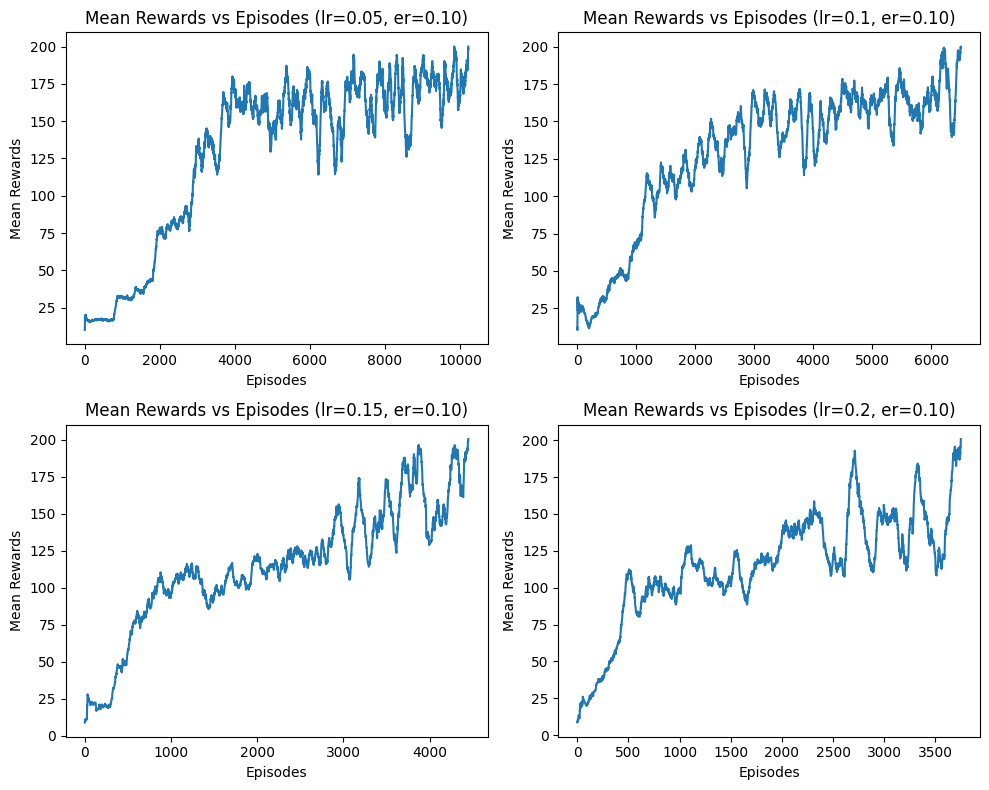

In [6]:
# Define learning rates
learning_rates = [0.05, 0.1, 0.15, 0.2]

agent = QLearningAgent(env) # Create a new agent

plt.figure(figsize=(10, 8)) # Create a figure to plot the rewards

i = 0
# Train the agent with different learning rates
for alpha in learning_rates:
    plt.subplot(2,2,i+1)
    agent.alpha = alpha # set learning rate
    agent.epsilon = 0.1 # reset epsilon
    agent.q = np.zeros((len(agent.pos_space)+1, len(agent.vel_space)+1, len(agent.ang_space)+1, len(agent.ang_vel_space)+1, agent.env.action_space.n)) # reset Q table
    
    agent.train(min_rewards=200, plot=True)
    # agent.save_model(f'cartpoleQLAgent_lr{alpha}.pkl')
    i += 1

plt.tight_layout()

#### Vary Initial Exploration Rate

What we want to do now is to investigate the effect of different initial exploration rate on the number of episodes needed to reach an average reward of 200.

Here we look at initial exploration rate at 0.1, 0.2, 0.3, 0.4 while keeping the initial learning rate of 0.1

Episode: 0 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 9.0
Episode: 100 Rewards: 40.0  Epsilon: 0.10  Mean Rewards 19.0
Episode: 200 Rewards: 8.0  Epsilon: 0.10  Mean Rewards 16.6
Episode: 300 Rewards: 30.0  Epsilon: 0.10  Mean Rewards 20.3
Episode: 400 Rewards: 38.0  Epsilon: 0.10  Mean Rewards 28.7
Episode: 500 Rewards: 11.0  Epsilon: 0.10  Mean Rewards 25.1
Episode: 600 Rewards: 20.0  Epsilon: 0.10  Mean Rewards 38.6
Episode: 700 Rewards: 52.0  Epsilon: 0.10  Mean Rewards 40.8
Episode: 800 Rewards: 59.0  Epsilon: 0.10  Mean Rewards 69.1
Episode: 900 Rewards: 41.0  Epsilon: 0.10  Mean Rewards 75.5
Episode: 1000 Rewards: 30.0  Epsilon: 0.10  Mean Rewards 87.7
Episode: 1100 Rewards: 168.0  Epsilon: 0.10  Mean Rewards 117.8
Episode: 1200 Rewards: 107.0  Epsilon: 0.10  Mean Rewards 114.8
Episode: 1300 Rewards: 65.0  Epsilon: 0.10  Mean Rewards 130.1
Episode: 1400 Rewards: 121.0  Epsilon: 0.10  Mean Rewards 141.2
Episode: 1500 Rewards: 131.0  Epsilon: 0.10  Mean Rewards 152.1
Episode: 1600 

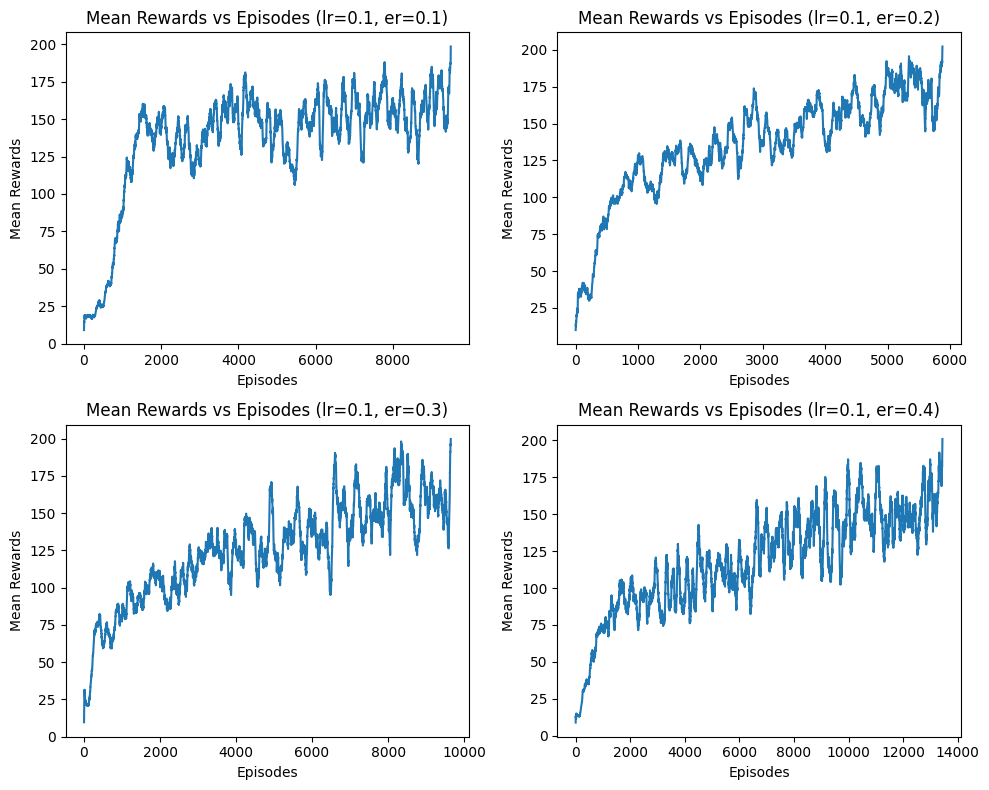

In [7]:
# Define exploration rates
exploration_rates = [0.1, 0.2, 0.3, 0.4]

agent = QLearningAgent(env) # Create a new agent

plt.figure(figsize=(10, 8)) # Create a figure to plot the rewards

i = 0
# Train the agent with different exploration rates
for epsilon in exploration_rates:
    plt.subplot(2,2,i+1)
    agent.alpha = 0.1 # reset learning rate
    agent.epsilon = epsilon # set exploration rate
    agent.q = np.zeros((len(agent.pos_space)+1, len(agent.vel_space)+1, len(agent.ang_space)+1, len(agent.ang_vel_space)+1, agent.env.action_space.n)) # reset Q table
    
    agent.train(min_rewards=200, plot=True)
    plt.title(f'Mean Rewards vs Episodes (lr={0.1}, er={epsilon})')
    # agent.save_model(f'cartpoleQLAgent_epsilon{epsilon}.pkl')
    i += 1

plt.tight_layout()

#### Choosing the best hyper parameters

Having done a very basic preliminary investigation on the hyper parameters, we decided to choose learning rate of 0.15 and initial exploration rate of 0.2 for our agent.

Now we will train the agent using the choosen hyper parameters

Episode: 0 Rewards: 12.0  Epsilon: 0.20  Mean Rewards 12.0
Episode: 100 Rewards: 8.0  Epsilon: 0.20  Mean Rewards 11.8
Episode: 200 Rewards: 9.0  Epsilon: 0.20  Mean Rewards 15.1
Episode: 300 Rewards: 56.0  Epsilon: 0.20  Mean Rewards 35.0
Episode: 400 Rewards: 47.0  Epsilon: 0.20  Mean Rewards 50.5
Episode: 500 Rewards: 37.0  Epsilon: 0.19  Mean Rewards 74.2
Episode: 600 Rewards: 17.0  Epsilon: 0.19  Mean Rewards 101.7
Episode: 700 Rewards: 15.0  Epsilon: 0.19  Mean Rewards 60.2
Episode: 800 Rewards: 143.0  Epsilon: 0.19  Mean Rewards 95.7
Episode: 900 Rewards: 81.0  Epsilon: 0.19  Mean Rewards 91.9
Episode: 1000 Rewards: 145.0  Epsilon: 0.19  Mean Rewards 98.9
Episode: 1100 Rewards: 101.0  Epsilon: 0.19  Mean Rewards 84.6
Episode: 1200 Rewards: 101.0  Epsilon: 0.19  Mean Rewards 95.8
Episode: 1300 Rewards: 56.0  Epsilon: 0.19  Mean Rewards 88.7
Episode: 1400 Rewards: 135.0  Epsilon: 0.19  Mean Rewards 96.3
Episode: 1500 Rewards: 21.0  Epsilon: 0.18  Mean Rewards 87.2
Episode: 1600 Re

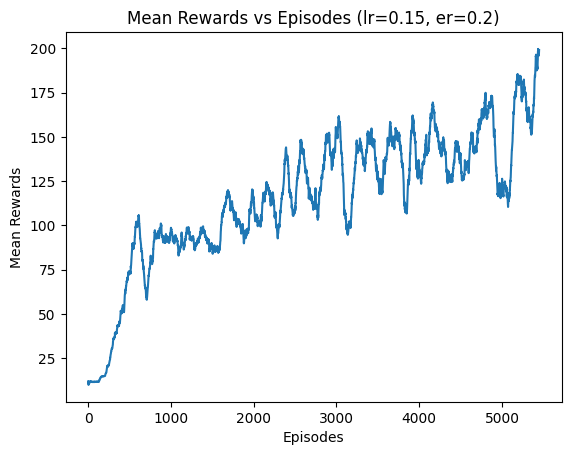

In [44]:
# Train the agent with lr = 0.15 and er = 0.2
agent = QLearningAgent(env)
agent.alpha = 0.15
agent.epsilon = 0.2
agent.train(min_rewards=200, plot=True)
plt.title(f'Mean Rewards vs Episodes (lr={0.15}, er={0.2})')
agent.save_model('cartpoleQLAgent.pkl')


# Task 2: Test the RL Agent

Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.   

## 2.1 Testing Q-learning Agent

Here we will load the pickle file containing the parameters for the Q-learning agent we have trained above.

Episode: 1 Rewards: 216.0
Episode: 2 Rewards: 169.0
Episode: 3 Rewards: 214.0
Episode: 4 Rewards: 160.0
Episode: 5 Rewards: 132.0
Episode: 6 Rewards: 181.0
Episode: 7 Rewards: 199.0
Episode: 8 Rewards: 165.0
Episode: 9 Rewards: 318.0
Episode: 10 Rewards: 158.0
Episode: 11 Rewards: 275.0
Episode: 12 Rewards: 181.0
Episode: 13 Rewards: 160.0
Episode: 14 Rewards: 281.0
Episode: 15 Rewards: 322.0
Episode: 16 Rewards: 256.0
Episode: 17 Rewards: 143.0
Episode: 18 Rewards: 236.0
Episode: 19 Rewards: 129.0
Episode: 20 Rewards: 180.0
Episode: 21 Rewards: 186.0
Episode: 22 Rewards: 339.0
Episode: 23 Rewards: 199.0
Episode: 24 Rewards: 150.0
Episode: 25 Rewards: 166.0
Episode: 26 Rewards: 203.0
Episode: 27 Rewards: 281.0
Episode: 28 Rewards: 230.0
Episode: 29 Rewards: 146.0
Episode: 30 Rewards: 164.0
Episode: 31 Rewards: 146.0
Episode: 32 Rewards: 203.0
Episode: 33 Rewards: 260.0
Episode: 34 Rewards: 232.0
Episode: 35 Rewards: 124.0
Episode: 36 Rewards: 255.0
Episode: 37 Rewards: 126.0
Episode: 3

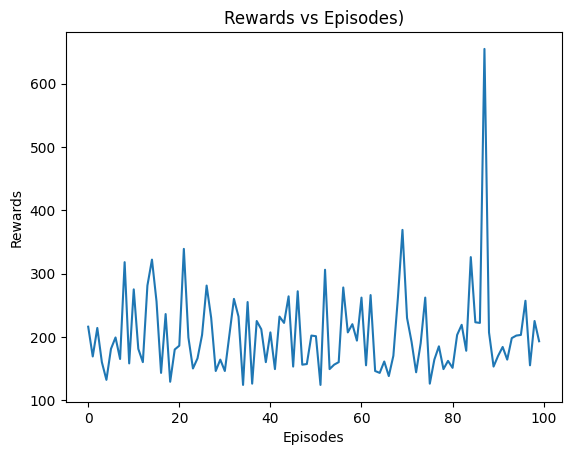

In [45]:
# Test the agent
env = gym.make('CartPole-v1')
agent = QLearningAgent(env)
agent.load_model('cartpoleQLAgent.pkl')
episode_results = agent.test(num_episodes=100, plot=True)

In [10]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 265.5
Is my agent good enough? True


# Task 3: Render

Render one episode played by the developed RL agent on Jupyter. Please refer to the sample code link for rendering code

In [47]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordVideo(env, './video')
agent = QLearningAgent(env)
agent.load_model('cartpoleQLAgent.pkl')
agent.run_one_episode(is_training=False)
env.close()
show_video()

Moviepy - Building video c:\Users\Oscar\OneDrive\Documents\NTU\Y2S2\SC3000-AI\SC3000-Projects\Project1\video\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Oscar\OneDrive\Documents\NTU\Y2S2\SC3000-AI\SC3000-Projects\Project1\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Oscar\OneDrive\Documents\NTU\Y2S2\SC3000-AI\SC3000-Projects\Project1\video\rl-video-episode-0.mp4


---
# Comparison to Deep Q-Learning Model

We will now explore the deep qlearning model and its implementation. Then we will compare it to our implementation of qlearning model.

# 1.1 Development of DQN Agent